You can also run this with the colab notebook: https://colab.research.google.com/drive/1CYY7Do854E7BLQCwkBZR2BhhEmO4Llmt?usp=sharing

# Deep Art Challenge - part 1 - The Bob Ross DCGAN
AI Impact Lab, Örebro University

## This is a Jupyter Notebook

A Jupyter Notebook is a great tool for creating interactive code tutorials. Runnable code is mixed with instructive text and explanations of what's going on. Put the mouse cursor in a code cell and press the play button to the left, or Ctrl-Enter, to execute it. An asterisc will be shown to the left of the cell when it is running. When finished it will show a sequenced number. If the code generates any output it will be shown below the code cell. Output can be anything from text and error reports to images, movies, and other media.

## Enable GPU support

Training a neural network involves heavy matrix computation. Using a GPU for this will speed up the process compared to using a regular CPU. On Kaggle you have 30 hours free GPU access per month. This is how you enable it:

* Find *Settings* in the sidebar.
* Select GPU as *Accelerator*. (Requires phone verification by SMS.)
* Wait for Kaggle to reconfigure and restart your session.

## Train your DCGAN

Completing this part of the challange is as easy as to run all code cells one by one. You can stop execution at any time by clicking *Cancel run* in the upper toolbar. If you get errors complaining about full disc space, you can start fresh by restarting the session by clicking the rotating arrows button in the toolbar. Don't be afraid to changing hyperparameters or tweaking the code to try and improve your results. You can always start anew by saving a new copy of the project template if you end up with lots of errors and can't find your way back to a working application.

Good luck!

### 1. Application setup

To make this notebook easier to read, most code has been put in a module called *dcgan*, that we import to the project. Implementation details has been abstracted away since they are beyond the scope of this challenge. But if you know a little Python you are more than welcome to take a look at the code to see what's going on under the hood. The implementation is far from optimal and you are more than welcome to improve it.

We also define a file path to where our image data is. You can find this folder in the sidebar.

In [84]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plot
import time

from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, ReLU, LeakyReLU, Dropout, UpSampling2D, Activation
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras import Sequential

# Default values
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_CHANNELS = 3
LEAKY_RELU_SLOPE = 0.2
DROPOUT_RATE = 0.5
WEIGHT_INIT_STD = 0.02
WEIGHT_INIT_MEAN = 0.0
LEARNING_RATE_INITIAL_D = 0.0002
LEARNING_RATE_INITIAL_G = 0.0002
NOISE_ARRAY_DIMENSION = 128
BATCH_SIZE = 16
LABEL_SMOOTHING = True
LABEL_NOISE = True

# TODO: try if loss_type is possible, refactor or remove.
# TODO: expose more hyperparams

class DCGAN():

    def __init__(self, hyperparameters):
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

        self.hyperparms = {
            "leaky_relu_slope": LEAKY_RELU_SLOPE,
            "dropout_rate": DROPOUT_RATE,
            "weight_init_std": WEIGHT_INIT_STD,
            "weight_init_mean": WEIGHT_INIT_MEAN,
            "learning_rate_initial_discriminator": LEARNING_RATE_INITIAL_D,
            "learning_rate_initial_generator": LEARNING_RATE_INITIAL_G,
            "noise_array_dimensions": NOISE_ARRAY_DIMENSION,
            "batch_size": BATCH_SIZE,
            "label_smoothing": LABEL_SMOOTHING,
            "label_noise": LABEL_NOISE
        }
        self.hyperparms.update(hyperparameters)

    def train(self, dataset, generator, discriminator, output_dir=".", epochs=50, save_every_x_results=40):
        noise_dim = self.hyperparms["noise_array_dimensions"]
        batch_size = self.hyperparms["batch_size"]
        lr_initial_g = self.hyperparms["learning_rate_initial_generator"]
        lr_initial_d = self.hyperparms["learning_rate_initial_discriminator"]

        # reused seed for plotting comparable images
        num_examples_to_generate = 5
        seed = tf.random.normal([num_examples_to_generate, noise_dim])

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=tf.Variable(lr_initial_g), beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=tf.Variable(lr_initial_d), beta_1=0.5)

        checkpoint_prefix = os.path.join(output_dir, "ckpt")
        checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                         discriminator_optimizer=discriminator_optimizer,
                                         generator=generator,
                                         discriminator=discriminator)

        all_g_loss = np.array([])
        all_d_loss = np.array([])

        for epoch in range(epochs):
            epoch_g_loss = []
            epoch_d_loss = []

            start = time.time()
            global_step = 0

            for image_batch in dataset:
                g_loss, d_loss = self.train_step(
                    generator,
                    generator_optimizer,
                    discriminator,
                    discriminator_optimizer,
                    image_batch,
                    batch_size,
                    noise_dim)

                global_step = global_step + 1
                epoch_g_loss.append(g_loss)
                epoch_d_loss.append(d_loss)
                all_g_loss = np.append(all_g_loss, np.array([epoch_g_loss]))
                all_d_loss = np.append(all_d_loss, np.array([epoch_d_loss]))

            if (epoch + 1) % save_every_x_results == 0 or epoch == 0:
                DCGAN.plot_losses(epoch_g_loss, epoch_d_loss, all_g_loss, all_d_loss, epoch + 1)
                DCGAN.generate_and_save_images(generator, epoch + 1, seed, output_dir)
                checkpoint.save(file_prefix = checkpoint_prefix)

            print("Epoch: {} computed for {} sec".format(epoch + 1, time.time() - start))
            print("Generator loss mean: ", np.mean(epoch_g_loss)," std: ", np.std(epoch_g_loss))
            print("Discriminator loss mean: ", np.mean(epoch_d_loss)," std: ", np.std(epoch_d_loss))

        DCGAN.generate_and_save_images(generator, epochs, seed, output_dir)
        checkpoint.save(file_prefix = checkpoint_prefix)

        print("Training completed.")

    def train_step(
            self,
            generator,
            generator_optimizer,
            discriminator,
            discriminator_optimizer,
            real_images, 
            batch_size, 
            noise_dim,
            loss_type="gan"):
        label_smoothing = self.hyperparms["label_smoothing"]
        label_noise = self.hyperparms["label_noise"]

        noise = tf.random.normal([batch_size, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)

            real_output = discriminator(real_images, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(
                real_output,
                fake_output,
                loss_type,
                apply_label_smoothing=label_smoothing)

            disc_loss = self.discriminator_loss(
                real_output,
                fake_output,
                loss_type,
                apply_label_smoothing=label_smoothing,
                label_noise=label_noise)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables))

        return gen_loss, disc_loss

    @staticmethod
    def plot_losses(epoch_g_loss, epoch_d_loss, all_g_loss, all_d_loss, epoch):
        plot.figure(figsize=(10, 5))
        plot.title("Epoch loss - EPOCH {}".format(epoch))
        plot.plot(epoch_g_loss, label="Generator")
        plot.plot(epoch_d_loss, label="Discriminator")
        plot.xlabel("Iterations")
        plot.ylabel("Loss")
        plot.legend()
        plot.show()

        plot.figure(figsize=(10, 5))
        plot.plot(np.arange(len(all_g_loss)), all_g_loss, label="Generator")
        plot.plot(np.arange(len(all_d_loss)), all_d_loss, label="Discriminator")
        plot.legend()
        plot.title("All epochs loss")
        plot.show()

    @staticmethod
    def generate_and_save_images(model, epoch, seed, output_dir):
        # Training is set to false to run in inference mode.
        predictions = model(seed, training=False)
        predictions_count = predictions.shape[0]

        for i in range(predictions_count):
            plot.figure(figsize=(3, 3))
            plot.imshow((predictions[i, :, :, :] * 127.5 + 127.5) / 255.)
            plot.axis("off")
            plot.savefig(output_dir + "/image-{}-at-epoch-{:05d}.png".format(i, epoch))
            plot.show()

    # Label smoothing -- technique from GAN hacks, instead of assigning
    # 1/0 as class labels, we assign a random integer in range [0.7, 1.0]
    # for positive class and [0.0, 0.3] for negative class.
    @staticmethod
    def smooth_positive_labels(y):
        rng = np.random.default_rng()
        return y - 0.3 * rng.random(y.shape)

    @staticmethod
    def smooth_negative_labels(y):
        rng = np.random.default_rng()
        return y + rng.random(y.shape) * 0.3

    # Instance noise -- randomly flip some labels
    @staticmethod
    def noisy_labels(y, p_flip):
        # determine the number of labels to flip
        n_select = int(p_flip * int(y.shape[0]))
        # choose labels to flip
        flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size=n_select)

        op_list = []
        # invert the labels in place
        #y_np[flip_ix] = 1 - y_np[flip_ix]
        for i in range(int(y.shape[0])):
            if i in flip_ix:
                op_list.append(tf.subtract(1, y[i]))
            else:
                op_list.append(y[i])

        outputs = tf.stack(op_list)
        return outputs

    def discriminator_loss(self, real_output, fake_output, loss_func, apply_label_smoothing=True, label_noise=True):
        real_labels = tf.ones_like(real_output)
        fake_labels = tf.zeros_like(fake_output)

        if label_noise:
            real_labels = DCGAN.noisy_labels(real_labels, 0.05)
            fake_labels = DCGAN.noisy_labels(fake_labels, 0.05)

        if apply_label_smoothing:
            real_labels = DCGAN.smooth_positive_labels(real_labels)
            fake_labels = DCGAN.smooth_negative_labels(fake_labels)

            # if loss_func == 'gan':
        real_loss = self.cross_entropy(real_labels, real_output)
        fake_loss = self.cross_entropy(fake_labels, fake_output)

        total_loss = real_loss + fake_loss
        return total_loss

        #     else:
        #         if loss_func == 'ralsgan':
        #             return (tf.reduce_mean(tf.math.square(real_output_smooth - tf.math.reduce_mean(fake_output_smooth) - tf.ones_like(real_output_smooth)))
        #     + tf.math.reduce_mean(tf.math.square(fake_output_smooth - tf.math.reduce_mean(real_output_smooth) + tf.ones_like(fake_output_smooth)))) / 2.
        #         elif loss_func == 'rasgan':
        #             avg_fake_logit = tf.math.reduce_mean(fake_output_smooth)
        #             avg_real_logit = tf.math.reduce_mean(real_output_smooth)
        #             D_r_tilde = tf.nn.sigmoid(real_output_smooth - avg_fake_logit)
        #             D_f_tilde = tf.nn.sigmoid(fake_output_smooth - avg_real_logit)
        #             total_loss = - tf.math.reduce_mean(tf.math.log(
        #                 D_r_tilde + 1e-14)) - tf.math.reduce_mean(tf.math.log(1 - D_f_tilde + 1e-14))
        #             return total_loss
        #         elif loss_func == 'rahinge':
        #             real_loss = tf.math.reduce_mean(tf.nn.relu(tf.ones_like(real_output_smooth) - (real_output_smooth - tf.math.reduce_mean(fake_output_smooth))))
        #             fake_loss = tf.math.reduce_mean(tf.nn.relu(tf.ones_like(fake_output_smooth) + (fake_output_smooth - tf.math.reduce_mean(real_output_smooth))))
            # total_loss = real_loss + fake_loss
            # return total_loss

    def generator_loss(self, real_output, fake_output, loss_func, apply_label_smoothing=True):
        fake_labels = tf.ones_like(fake_output)
        if apply_label_smoothing:
            fake_labels = DCGAN.smooth_positive_labels(fake_labels)

            # if loss_func == 'gan':
        return self.cross_entropy(fake_labels, fake_output)
        #     else:
        #         if loss_func == 'ralsgan':
        #             return (tf.reduce_mean(tf.square(real_output - tf.reduce_mean(fake_output_smooth) + tf.ones_like(real_output)))
        #     + tf.reduce_mean(tf.square(fake_output_smooth - tf.reduce_mean(real_output) - tf.ones_like(fake_output_smooth)))) / 2.
        #         elif loss_func == 'rasgan':
        #             avg_fake_logit = tf.reduce_mean(fake_output_smooth)
        #             avg_real_logit = tf.reduce_mean(real_output)
        #             D_r_tilde = tf.nn.sigmoid(real_output - avg_fake_logit)
        #             D_f_tilde = tf.nn.sigmoid(fake_output_smooth - avg_real_logit)
        #             total_loss = - tf.reduce_mean(tf.log(
        #                 D_f_tilde + 1e-14)) - tf.reduce_mean(tf.log(1 - D_r_tilde + 1e-14))
        #             return total_loss
        #         elif loss_func == 'rahinge':
        #             fake_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(fake_output_smooth) - (fake_output_smooth - tf.reduce_mean(real_output))))
        #             real_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(real_output) + (real_output - tf.reduce_mean(fake_output_smooth))))
        #             loss = fake_loss + real_loss
        #             return loss

    def upsampling(self, model, filters, kernel_size=(5, 5), strides=(1, 1)):
        model.add(UpSampling2D(size=(2, 2)))
        model.add(Conv2D(filters, kernel_size, strides=strides, padding="same"))
        model.add(Activation("tanh"))
        return model

    def weight_initializer(self):
        weight_init_std = self.hyperparms["weight_init_std"]
        weight_init_mean = self.hyperparms["weight_init_mean"]
        return TruncatedNormal(stddev=weight_init_std, mean=weight_init_mean, seed=42)

    def transposed_conv(self, model, out_channels, ksize, stride_size, padding_type="same"):
        initializer = self.weight_initializer()
        model.add(Conv2DTranspose(
            out_channels,
            (ksize, ksize),
            strides=(stride_size, stride_size),
            padding=padding_type, 
            kernel_initializer=initializer,
            use_bias=False))
        model.add(BatchNormalization())
        model.add(ReLU())
        return model

    def conv(self, model, out_channels, ksize, stride_size, leaky_relu_slope, padding_type="same"):
        initializer = self.weight_initializer()
        model.add(Conv2D(
            out_channels, 
            (ksize, ksize), 
            strides=(stride_size, stride_size), 
            padding=padding_type,
            kernel_initializer=initializer))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=leaky_relu_slope))
        return model

    def build_generator(self):
        initializer = self.weight_initializer()
        noise_dim = self.hyperparms["noise_array_dimensions"]
        dropout_rate = self.hyperparms["dropout_rate"]

        # noise_dim * 1 (noise)     project and reshape
        # 4 * 4 * 1024              conv 1
        # 8 * 8 * 512               conv 2
        # 16 * 16 * 256             conv 3
        # 32 * 32 * 128             conv 4
        # 64 * 64 * 3

        model = Sequential()
        model.add(Dense(4 * 4 * 1024, input_shape=(noise_dim,), kernel_initializer=initializer))
        model.add(Reshape((4, 4, 1024)))

        model = self.upsampling(model, 256, (5, 5))
        model.add(Dropout(dropout_rate))
        model = self.upsampling(model, 128, (5, 5))
        model.add(Dropout(dropout_rate))
        model = self.upsampling(model, 64, (3, 3))
        model.add(Dropout(dropout_rate))
        model = self.upsampling(model, 32, (3, 3))

        model.add(Dense(IMAGE_CHANNELS, activation="tanh", kernel_initializer=initializer))
        return model

    def build_discriminator(self):
        leaky_relu_slope = self.hyperparms["leaky_relu_slope"]
        dropout_rate = self.hyperparms["dropout_rate"]
        initializer = self.weight_initializer()

        model = Sequential()

        model.add(Conv2D(
            64,
            (4, 4),
            strides=(1, 1),
            padding="same",
            use_bias=False,
            input_shape=[IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS],
            kernel_initializer=initializer))
        model.add(LeakyReLU(alpha=leaky_relu_slope))

        model.add(Dropout(dropout_rate))
        model = self.conv(model, 64, 4, 2, leaky_relu_slope)
        model.add(Dropout(dropout_rate))
        model = self.conv(model, 128, 4, 2, leaky_relu_slope)
        model.add(Dropout(dropout_rate))
        model = self.conv(model, 256, 4, 2, leaky_relu_slope)

        model.add(Flatten())
        model.add(Dense(1, activation="sigmoid"))
        return model

    def create_dataset(self, image_dir):
        image_height = IMAGE_HEIGHT
        image_width = IMAGE_WIDTH
        image_channels = IMAGE_CHANNELS
        batch_size = self.hyperparms["batch_size"]

        image_list = os.listdir(image_dir)
        image_count = len(image_list)

        training_data = np.empty((image_count, image_height, image_width, image_channels))

        plot.figure(figsize=(10, 10))

        index = 0
        for filename in image_list:
            path = os.path.join(image_dir, filename)
            original = Image.open(path)

            image = original.resize((image_width, image_height), Image.BICUBIC)
            training_data[index,:,:,:] = np.asarray(image)
            index += 1

            if index <= 30:
                plot.xticks([])
                plot.yticks([])
                plot.grid(False)
                plot.subplot(5, 6, index)
                plot.imshow(image)

        plot.show()

        # normalize pixel value range to [-1, 1]
        training_data = (training_data - 127.5) / 127.5

        tensor = tf.cast(training_data, "float32")

        return tf.data.Dataset.from_tensor_slices(tensor).shuffle(10000).batch(batch_size, drop_remainder=True)

In [ ]:

%pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import gdown


url = 'https://drive.google.com/uc?id=1NjJazM-fgg5WB2IAS-oBc0By7PwaSAsU'

output='imgs.zip'
gdown.download(url,  output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1NjJazM-fgg5WB2IAS-oBc0By7PwaSAsU
To: /content/imgs.zip
100%|██████████| 83.7M/83.7M [00:00<00:00, 333MB/s]


'imgs.zip'

In [ ]:

!mkdir imgs
!unzip -d imgs/ imgs.zip

Archive:  imgs.zip
  inflating: imgs/001.png            
  inflating: imgs/002.png            
  inflating: imgs/003.png            
  inflating: imgs/004.png            
  inflating: imgs/005.png            
  inflating: imgs/006.png            
  inflating: imgs/007.png            
  inflating: imgs/008.png            
  inflating: imgs/009.png            
  inflating: imgs/010.png            
  inflating: imgs/011.png            
  inflating: imgs/012.png            
  inflating: imgs/013.png            
  inflating: imgs/014.png            
  inflating: imgs/015.png            
  inflating: imgs/016.png            
  inflating: imgs/017.png            
  inflating: imgs/018.png            
  inflating: imgs/019.png            
  inflating: imgs/020.png            
  inflating: imgs/021.png            
  inflating: imgs/022.png            
  inflating: imgs/023.png            
  inflating: imgs/024.png            
  inflating: imgs/025.png            
  inflating: imgs/027.png      

In [2]:
!git clone https://github.com/aoertel/bob-ross-challenge-wasp.git

Cloning into 'bob-ross-challenge-wasp'...
remote: Enumerating objects: 3074, done.
remote: Counting objects: 100% (357/357), done.
remote: Compressing objects: 100% (353/353), done.
remote: Total 3074 (delta 5), reused 355 (delta 4), pack-reused 2717
Receiving objects: 100% (3074/3074), 755.75 MiB | 52.08 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Checking out files: 100% (3054/3054), done.


In [11]:
!rm -rf imgs
!mkdir imgs
!cp bob-ross-challenge-wasp/augmented/*.png imgs/
!cp bob-ross-challenge-wasp/curated/*.png imgs/
IMAGE_DIR = "./imgs"

### 2. Define hyperparameters

In machine learning we separate parameters from hyperparameters. Hyperparameters are all parameters that are set before starting the training process. The other parameters or weights are learnt automatically in the training process. Different settings of the hyperparameters can make a huge effect on the outcome of the training.

In [89]:
# Our first try parameters
hyperparameters = {
    "leaky_relu_slope": 0.2,
    "dropout_rate": 0.5,
    "weight_init_std": 0.5,
    "weight_init_mean": 0.0,
    "learning_rate_initial_discriminator": 0.001,
    "learning_rate_initial_generator": 0.01,
    "noise_array_dimensions": 50,
    "batch_size": 16,
    "label_smoothing": True,
    "label_noise": True
}

# Modified default parameters
hyperparameters = {
    "leaky_relu_slope": 0.2,
    "dropout_rate": 0.5,
    "weight_init_std": 0.1,
    "weight_init_mean": 0.0,
    "learning_rate_initial_discriminator": 0.01,
    "learning_rate_initial_generator": 0.01,
    "noise_array_dimensions": 128,
    "batch_size": 16,
    "label_smoothing": True,
    "label_noise": True
}
dcgan = DCGAN(hyperparameters)

### 3. Create training dataset

The images in the input folder are preprocessed and stored in a binary format that the training algorithm can work efficiently with. Each image is also downsampled to 64 by 64 pixels to reduce the training time. This code cell should output a few example images from the training dataset. 

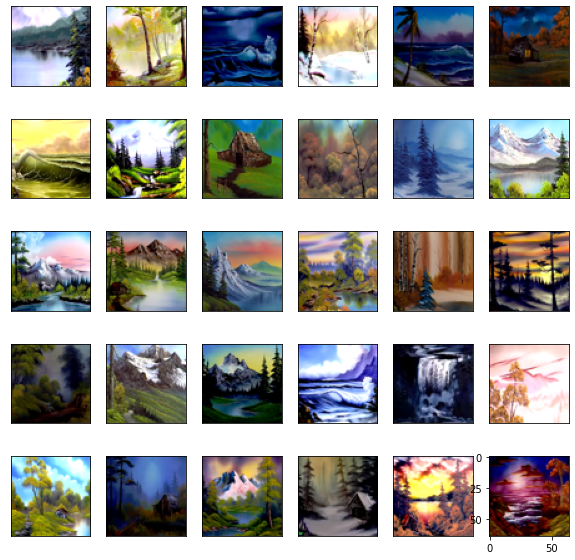

In [90]:
dataset = dcgan.create_dataset(IMAGE_DIR)

### 4. Generator and Discriminator

The DCGAN architecture is basically two neural networks competing against each other in the training process. The discriminator takes an image as input and is trained to predict if the image is real or fake. Real in this case means being part of the dataset we trained the model on. The generator takes some noise as input and is trained to fool the discriminator by generating images that resemble the images of the training dataset to a level that the discriminator can not tell them apart from real images.

In [91]:
generator = dcgan.build_generator()
discriminator = dcgan.build_discriminator()

### 5. The training process

To start training we pass the dataset, generator and discriminator to the *train* function. We also specify how many epochs we want the process to repeat, and we tell it to plot and display generated images for every x epoch. Doing this at every iteration would soon fill the disc space we are allowed to use on Kaggle.

When training starts both networks are equally bad. The discriminator predictions will be random and the generator will produce random noise images. As the training goes on both networks should become better at their tasks because the results are fed back in the training loop and progress in the generator should trigger progress in the discriminator and vice versa.

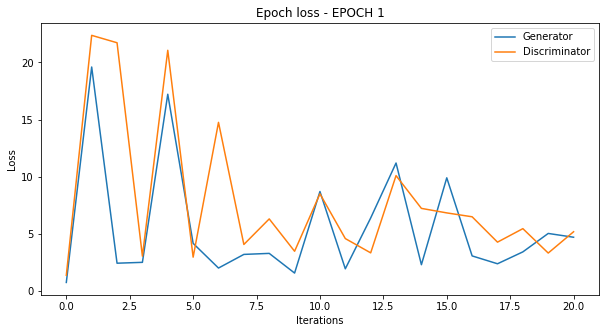

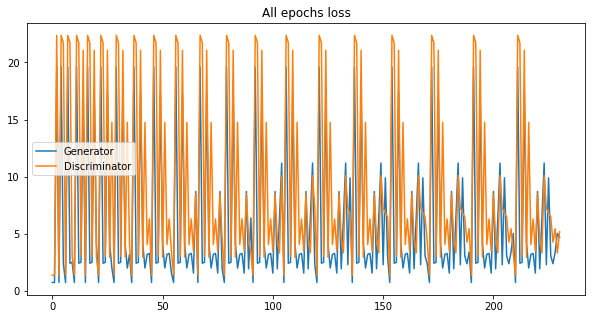

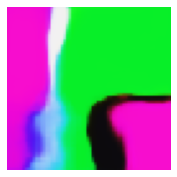

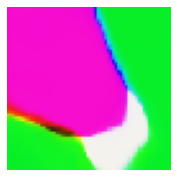

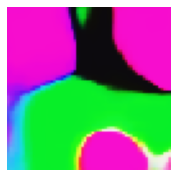

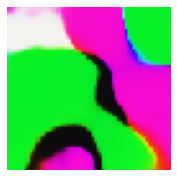

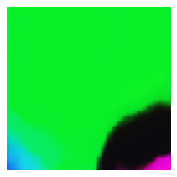

Epoch: 1 computed for 3.4849722385406494 sec
Generator loss mean:  5.513207  std:  4.9898705
Discriminator loss mean:  7.9253626  std:  6.307111
Epoch: 2 computed for 2.0061795711517334 sec
Generator loss mean:  2.753521  std:  1.5252801
Discriminator loss mean:  3.991596  std:  1.9418046
Epoch: 3 computed for 1.996312141418457 sec
Generator loss mean:  1.9523187  std:  0.94277495
Discriminator loss mean:  2.7051058  std:  0.76190895
Epoch: 4 computed for 2.0053014755249023 sec
Generator loss mean:  1.7225313  std:  0.5830939
Discriminator loss mean:  2.185219  std:  0.5301856
Epoch: 5 computed for 1.9746530055999756 sec
Generator loss mean:  1.3862703  std:  0.67283356
Discriminator loss mean:  1.8277047  std:  0.5180613
Epoch: 6 computed for 2.0084056854248047 sec
Generator loss mean:  1.2001948  std:  0.38198382
Discriminator loss mean:  1.5161581  std:  0.30613586
Epoch: 7 computed for 1.9913709163665771 sec
Generator loss mean:  1.245923  std:  0.24888058
Discriminator loss mean: 

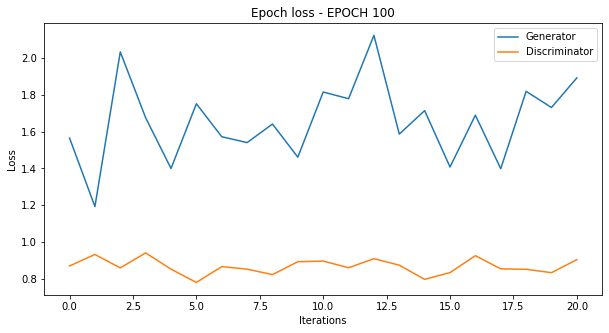

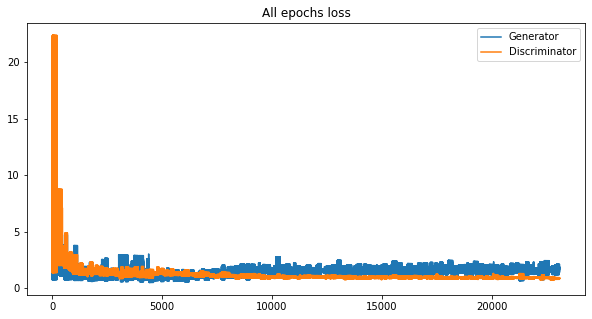

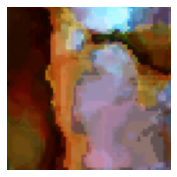

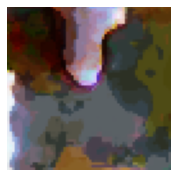

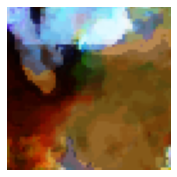

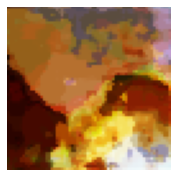

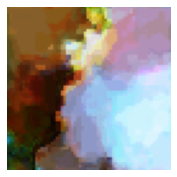

Epoch: 100 computed for 3.2324886322021484 sec
Generator loss mean:  1.656535  std:  0.2167139
Discriminator loss mean:  0.8658279  std:  0.04117272


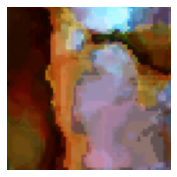

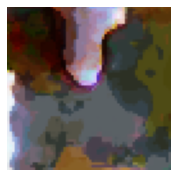

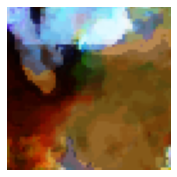

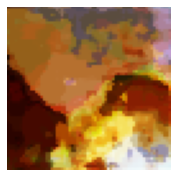

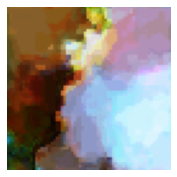

Training completed.


In [92]:
dcgan.train(
    dataset,
    generator, 
    discriminator,
    epochs=100,
    save_every_x_results=100)

### 6. Evaluating trainging progress

As you can see in the output above, each training epoch runs for a few seconds (at least for the initial configuration). For each epoch a *loss* value is computed for both the generator and discriminator. This value is a measure of how far off from the truth the network is when making a prediction. A lower value means the prediction is better. The loss value is what is fed back from one iteration to the next to enable learning of the neural network weights. The loss value is fed into an *optimizer* function that calculates how the weights should be adjusted for the network to improve. How the optimizer works is beyond the scope of this excercise. The loss values are easier to reason about here. If you are able to run a successfull training session for long enough, you will see in the *All epochs loss* graph how the loss values go up and down all the time but starts stabilizing at different levels after some number of iterations. When training for example an image object detection network for detecting different animals, you will see the loss value decrease to a more stable low number, with less variance. But when training a GAN the loss values will keep fluctuating. This is because the generator and discriminator keep competing and influencing each others loss function.

How do you know training is complete? You don't! You'll have to watch the output and decide when you think the results stop improving. You should also interupt training if the DCGAN doesn't seem to learn anything and the generator keeps generating random noise images.

### 7. Try different hyperparameters

Now go back to the code cell where we defined hyperparameters. Change some values, run all code cells again, and see if you can improve the results. There are plenty articles on the web that can guide you to hyperparameter settings for stable training of a DCGAN. If you know Python programming you can make a copy of the dcgan utility script and see if you can do any changes to the code to improve your results.